In [12]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt 
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

import FCPython

In [26]:
df = pd.read_csv('./../../data/wyscout_tabular/events_World_Cup.csv')

In [27]:
shots = df[df['eventName'] == 'Shot'] #6898 tiros totales

#extraer goles
goals = shots[(shots['tag_0'] == 101) | #747 goles de tiros
                  (shots['tag_1'] == 101) |
                  (shots['tag_2'] == 101) |
                  (shots['tag_3'] == 101) |
                  (shots['tag_4'] == 101) |
                  (shots['tag_5'] == 101)] 

In [28]:
data = df.copy()

#Create a data set of shots.
train = pd.DataFrame(data)
pd.unique(train['subEventName'])
shots=train[train['subEventName']=='Shot']
shots_model=pd.DataFrame(columns=['Goal','X','Y'])

In [29]:
#tarda mil años
for i,shot in shots.iterrows():
    
    header=0
    if ((shot['tag_0'] == 403) | #747 goles de tiros
                  (shot['tag_1'] == 403) |
                  (shot['tag_2'] == 403) |
                  (shot['tag_3'] == 403) |
                  (shot['tag_4'] == 403) |
                  (shot['tag_5'] == 403)):
        header = 1
        
    #Only include non-headers        
    if not(header):        
        shots_model.at[i,'X']=100-shot['x_inicio']
        shots_model.at[i,'Y']=shot['y_inicio']
        shots_model.at[i,'C']=abs(shot['y_inicio']-50)
    
        #Distance in metres and shot angle in radians.
        x=shots_model.at[i,'X']*105/100
        y=shots_model.at[i,'C']*65/100
        shots_model.at[i,'Distance']=np.sqrt(x**2 + y**2)
        a = np.arctan(7.32 *x /(x**2 + y**2 - (7.32/2)**2))
        if a<0:
            a=np.pi+a
        shots_model.at[i,'Angle'] =a
    
        #Was it a goal
        shots_model.at[i,'Goal']=0
        
        if ((shot['tag_0'] == 101) | #747 goles de tiros
                  (shot['tag_1'] == 101) |
                  (shot['tag_2'] == 101) |
                  (shot['tag_3'] == 101) |
                  (shot['tag_4'] == 101) |
                  (shot['tag_5'] == 101)):
            shots_model.at[i,'Goal']=1 

In [30]:
shots_model[shots_model['Goal'] == 1] # 603 goals

,Goal,X,Y,C,Distance,Angle
709,1,7,38,12.0,10.717392,0.487547
1555,1,14,29,21.0,20.060222,0.269858
4382,1,7,58,8.0,9.003472,0.671746
4405,1,11,60,10.0,13.253396,0.480355
5310,1,6,54,4.0,6.815424,0.948906
...,...,...,...,...,...,...
100095,1,13,42,8.0,14.606933,0.463386
100731,1,13,42,8.0,14.606933,0.463386
101216,1,15,45,5.0,16.081822,0.439468
101320,1,25,56,6.0,26.538133,0.271269


In [31]:

squaredX = shots_model['X']**2
shots_model = shots_model.assign(X2=squaredX)
squaredC = shots_model['C']**2
shots_model = shots_model.assign(C2=squaredC)
AX = shots_model['Angle']*shots_model['X']
shots_model = shots_model.assign(AX=AX)


model_variables = ['Angle','Distance']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

In [32]:
#Fit the model
test_model = smf.glm(formula="Goal ~ " + model, data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params


#Return xG value for more general model
def calculate_xG(sh):    
    bsum=b[0]
    for i,v in enumerate(model_variables):
        bsum=bsum+b[i+1]*sh[v]
    xG = 1/(1+np.exp(bsum)) 
    
    return xG   

                   Generalized Linear Model Regression Results                    
Dep. Variable:     ['Goal[0]', 'Goal[1]']   No. Observations:                 1179
Model:                                GLM   Df Residuals:                     1176
Model Family:                    Binomial   Df Model:                            2
Link Function:                      Logit   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:                -273.20
Date:                    Mon, 21 Nov 2022   Deviance:                       546.40
Time:                            21:00:10   Pearson chi2:                 1.17e+03
No. Iterations:                         7   Pseudo R-squ. (CS):            0.09609
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [33]:
#Add an xG to my dataframe
xG=shots_model.apply(calculate_xG, axis=1) 
shots_model = shots_model.assign(xG=xG)

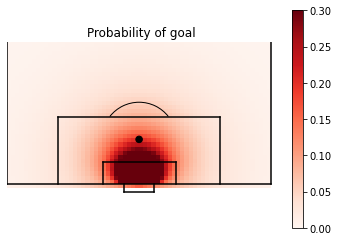

In [34]:
#Create a 2D map of xG
pgoal_2d=np.zeros((65,65))
for x in range(65):
    for y in range(65):
        sh=dict()
        a = np.arctan(7.32 *x /(x**2 + abs(y-65/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        sh['Angle'] = a
        sh['Distance'] = np.sqrt(x**2 + abs(y-65/2)**2)
        sh['D2'] = x**2 + abs(y-65/2)**2
        sh['X'] = x
        sh['AX'] = x*a
        sh['X2'] = x**2
        sh['C'] = abs(y-65/2)
        sh['C2'] = (y-65/2)**2
        
        pgoal_2d[x,y] =  calculate_xG(sh)

(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(pgoal_2d, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.3)
fig.colorbar(pos, ax=ax)
ax.set_title('Probability of goal')
plt.xlim((0,66))
plt.ylim((-3,35))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
#fig.savefig('Output/goalprobfor_' + model  + '.pdf', dpi=None, bbox_inches="tight")   